In [1]:
import pandas as pd
import numpy as np
import warnings
import math

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))
warnings.filterwarnings('ignore')

We try to find client will pay their repayment if we give them credit in our bank. We try to solve this problem according to client bureau, installment payments and current payments history. We try to analyze clients and their behaviours about their debts. By using that we can determine that clients are reliable or not. By using this system, Bank can choose their client more efficient way and they do not need to suffer days past due payments. In this notebook following index is followed;

**INDEX : **
    
    1) Extra Data Sources Analysis and Scoring
        1.1) Installment Payments
        1.2) Bureau
    2) Exploratory Data Analysis
        2.1) Missing Values
        2.2) Anomalies in Features
            2.2.1) DAYS_BIRTH
            2.2.2) DAYS_EMPLOYED
            2.2.3) DAYS_REGISTRATION
        2.3) Relationship with Target Variables
            2.3.1) EXT_SOURCE_2
            2.3.2) DAYS_EMPLOYED
    3) Feature Engineering
    4) Feature Importance and Target Variable Analysis
        4.1) RandomForestClassifier for Feature Importance
        4.2) Logistic Regression
            4.2.1) DAYS_ID_PUBLISH
            4.2.2) DAYS_LAST_PHONE_CHANGE
    5) Models Implementation and Feature Elimination
        5.1) Principal Component Analysis without Boostrap Sampling
        5.2) Principal Component Analysis with Boostrap Resampling
    6) Conclusion
            

# 1) Extra Data Sources Analysis and Scoring

In order to analyze credit risk of our clients, we have to analyze their behaviours. In this notebook we analyze their installment payments and bureau data sources. We analyze these data sources and merge them with main table. All of client history is important for us but a lot of features misdirect us for knowledge of client behaviour. Then we have to decrease features by analyzing extra data sources. We try to decrease features in data sources by scoring clients.

## 1.1) Installment Payments

In order to score their installment payment behaviour that we need to segment our client and then we score them. We can determine this by using DAYS_ columns and AMT_ columns. First we need to look client payment status. We look most reliable client in this records. For example one client pay his all debt and pay it 2700 day before to due date then this client take 100 from installment payments. Then score decrease according to their performance.

We score our clients according to this formula:
$$Score =100 - (\frac{(\frac {Days past Due Date}{MaximumPast} + \frac {Remaining Debt}{Maximum Remaining Debt})}{2} * 100) $$

In [2]:
installment_payments = pd.read_csv("/home/atakansoztekin/Desktop/ML Projects/Kaggle/Home Credit Default Risk/data/installments_payments.csv")
installment_payments.dropna(inplace=True)

installment_payments_new = installment_payments.groupby(['SK_ID_CURR','SK_ID_PREV','NUM_INSTALMENT_NUMBER'],as_index=False).mean()
installment_payments_new['AMT_INSTALMENT'] = np.round(installment_payments.groupby(['SK_ID_CURR','SK_ID_PREV','NUM_INSTALMENT_NUMBER'],as_index=False).sum()['AMT_INSTALMENT'],decimals=3)

l = installment_payments_new[installment_payments_new.AMT_PAYMENT>installment_payments_new.AMT_INSTALMENT].index
installment_payments_new.drop(index=l,inplace=True)

installment_payments_new['payment'] = installment_payments_new.AMT_INSTALMENT-installment_payments_new.AMT_PAYMENT
installment_payments_new['days'] = installment_payments_new.iloc[:,4]-installment_payments_new.iloc[:,5]
early_max = np.min(installment_payments_new.DAYS_INSTALMENT-installment_payments_new.DAYS_ENTRY_PAYMENT)
installment_payments_new.days = installment_payments_new.days - early_max

installment_payments_new['score'] = 100 - (((installment_payments_new.days/np.max(installment_payments_new.days)) + (installment_payments_new.payment/np.max(installment_payments_new.payment)))/2*100)

score_last_installment = installment_payments_new.groupby(['SK_ID_CURR'],as_index=False)['score'].mean()

## 1.2) Bureau

In order to score their bureau payment behaviour, we need to look for their current debt, days overdue and account is active or closed. Our score metric will be;
$$IF(CREDITDAYOVERDUE != 0) \quad score = 100-(\frac{(\frac {CREDITDAYOVERDUE}{MAXCREDITDAYOVERDUE} + \frac {AMTCREDITSUMOVERDUE}{MAXAMTCREDITSUMOVERDUE})}{2}*100) $$
ELSE
$$IF(CREDITDAYOVERDUE == 0) \quad AND \quad IF(CREDITACTIVE == CLOSED) \quad score = (\frac {\frac {AMTCREDITSUM}{DAYSCREDITENDDATE-DAYSCREDIT}}{MAX(\frac {AMTCREDITSUM}{DAYSCREDITENDDATE-DAYSCREDIT})})*100$$
ELSE
$$IF(CREDITDAYOVERDUE == 0) \quad AND \quad IF(CREDITACTIVE == ACTIVE) \quad score = (\frac {\frac {AMTCREDITSUM-AMTCREDITSUMDEBT}{DAYSCREDITENDDATE-DAYSCREDIT}}{MAX(\frac {AMTCREDITSUM-AMTCREDITSUMDEBT}{DAYSCREDITENDDATE-DAYSCREDIT})})*100$$
<br>
After looking clients installment payments and bureau history, we can use these score variables in our main table. Now we can start analysis of data towards to target variable.
<br>
<br>

In [3]:
bureau = pd.read_csv("/home/atakansoztekin/Desktop/ML Projects/Kaggle/Home Credit Default Risk/data/bureau.csv")

bureau_new = bureau.groupby(['SK_ID_CURR','SK_ID_BUREAU','CREDIT_ACTIVE'],as_index=False).mean()
bureau_new['score'] = np.nan

l1 = bureau_new[bureau_new.CREDIT_DAY_OVERDUE!=0].index
bureau_new.loc[l1,'score'] =100-(((bureau_new.loc[l1,'CREDIT_DAY_OVERDUE']/np.max(bureau_new.loc[l1,'CREDIT_DAY_OVERDUE']))+(bureau_new.loc[l1,'AMT_CREDIT_SUM_OVERDUE']/np.max(bureau_new.loc[l1,'AMT_CREDIT_SUM_OVERDUE'])))/2*100) 

l2 = bureau_new[(bureau_new.CREDIT_DAY_OVERDUE==0)&(bureau_new.CREDIT_ACTIVE=='Closed')].index
divisionl2 = bureau_new.loc[l2,'AMT_CREDIT_SUM']/(bureau_new.loc[l2,'DAYS_CREDIT_ENDDATE']-bureau_new.loc[l2,'DAYS_CREDIT'])
divisionl2.replace([np.inf, -np.inf], np.nan,inplace=True)
bureau_new.loc[l2,'score'] = (divisionl2 / np.max(divisionl2))*100


l3 = bureau_new[(bureau_new.CREDIT_DAY_OVERDUE==0)&(bureau_new.CREDIT_ACTIVE=='Active')].index
divisionl3 = (bureau_new.loc[l3,'AMT_CREDIT_SUM']-bureau_new.loc[l3,'AMT_CREDIT_SUM_DEBT'])/(bureau_new.loc[l3,'DAYS_CREDIT_ENDDATE']-bureau_new.loc[l3,'DAYS_CREDIT'])
divisionl3.replace([np.inf, -np.inf], np.nan,inplace=True)
bureau_new.loc[l3,'score'] = (divisionl3 / np.max(divisionl3))*100

score_last_bureau = bureau_new.groupby(['SK_ID_CURR'],as_index=False)['score'].mean()
score_last_bureau.dropna(subset=['score'],inplace=True)

# 2) Exploratory Data Analysis

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

application_train = pd.read_csv("/home/atakansoztekin/Desktop/ML Projects/Kaggle/Home Credit Default Risk/data/application_train.csv")
application_test = pd.read_csv("/home/atakansoztekin/Desktop/ML Projects/Kaggle/Home Credit Default Risk/data/application_test.csv")
target_variable = application_train.TARGET
application_train.drop('TARGET',axis=1,inplace=True)

#Bureau and installment score matching
application_train['bureau_score']=np.nan
application_train['installment_score']=np.nan

l = list(score_last_bureau.SK_ID_CURR)
l_last = list(application_train[application_train.SK_ID_CURR.isin(l)]['SK_ID_CURR'])
application_train.loc[application_train.SK_ID_CURR.isin(l_last),'bureau_score']=score_last_bureau.loc[score_last_bureau.SK_ID_CURR.isin(l_last),'score'].values

l2 = list(score_last_installment.SK_ID_CURR)
l2_last = list(application_train[application_train.SK_ID_CURR.isin(l2)]['SK_ID_CURR'])
application_train.loc[application_train.SK_ID_CURR.isin(l2_last),'installment_score']=score_last_installment.loc[score_last_installment.SK_ID_CURR.isin(l2_last),'score'].values

application_test['bureau_score']=np.nan
application_test['installment_score']=np.nan

l = list(score_last_bureau.SK_ID_CURR)
l_last = list(application_test[application_test.SK_ID_CURR.isin(l)]['SK_ID_CURR'])
application_test.loc[application_test.SK_ID_CURR.isin(l_last),'bureau_score']=score_last_bureau.loc[score_last_bureau.SK_ID_CURR.isin(l_last),'score'].values

l2 = list(score_last_installment.SK_ID_CURR)
l2_last = list(application_test[application_test.SK_ID_CURR.isin(l2)]['SK_ID_CURR'])
application_test.loc[application_test.SK_ID_CURR.isin(l2_last),'installment_score']=score_last_installment.loc[score_last_installment.SK_ID_CURR.isin(l2_last),'score'].values

## 2.1) Missing Values

First of all we needed to look missing values in data. Without that we cannot determine which variable is more effect on target variable. We start with calculate missing values, if variable have %20 NaN then we can drop this variable. Because if we try to impute these variables, we change characteristics of data and this can mislead us. If variable have less than %20 Nan values, we look correlation matrix for this variable and try to fill these values according to that. But before we fill missing values we need to encode categorical variables(We use Will Koehrsen notebook codes). Then we look for missing values and use following formula for handling missing values;

$IF(NANPERCENTAGE > 0.2)$ Then Drop Columns

$IF(NANPERCENTAGE <= 0.2 \& NANPERCENTAGE > 0)$ Then Fill missing values with median of columns

We do last method because small amount of Nan values do not change characteristics of predictive variable.

In [5]:
# %20 or more missing values handling
missing_values = pd.DataFrame(np.ones(shape=(123,2)),columns=['Columns','Total NaNs'])
missing_values['Columns'] = application_train.isnull().sum().index
missing_values['Total NaNs'] = application_train.isnull().sum().values

missing_values['NanP'] = missing_values['Total NaNs'] / len(application_train)

droped_columns = missing_values.loc[missing_values.NanP>0.2,'Columns']
application_train.drop(droped_columns,inplace=True,axis=1)

In [6]:
missing_values = pd.DataFrame(np.ones(shape=(123,2)),columns=['Columns','Total NaNs'])
missing_values['Columns'] = application_test.isnull().sum().index
missing_values['Total NaNs'] = application_test.isnull().sum().values

missing_values['NanP'] = missing_values['Total NaNs'] / len(application_test)

droped_columns = missing_values.loc[missing_values.NanP>0.2,'Columns']
application_test.drop(droped_columns,inplace=True,axis=1)

In [7]:
application_train.dtypes.value_counts()

int64      40
float64    22
object     11
dtype: int64

In [8]:
application_train.select_dtypes('object').apply(pd.Series.nunique, axis = 0)

NAME_CONTRACT_TYPE             2
CODE_GENDER                    3
FLAG_OWN_CAR                   2
FLAG_OWN_REALTY                2
NAME_TYPE_SUITE                7
NAME_INCOME_TYPE               8
NAME_EDUCATION_TYPE            5
NAME_FAMILY_STATUS             6
NAME_HOUSING_TYPE              6
WEEKDAY_APPR_PROCESS_START     7
ORGANIZATION_TYPE             58
dtype: int64

In [9]:
# Categorical Variable Handling

from sklearn.preprocessing import LabelEncoder,OneHotEncoder
# Create a label encoder object
le = LabelEncoder()
le_count = 0

# Iterate through the columns
for col in application_train:
    if application_train[col].dtype == 'object':
        # If 2 or fewer unique categories
        if len(list(application_train[col].unique())) <= 2:
            # Train on the training data
            le.fit(application_train[col])
            # Transform both training and testing data
            application_train[col] = le.transform(application_train[col])
            application_test[col] = le.transform(application_test[col])

# one-hot encoding of categorical variables
application_train = pd.get_dummies(application_train)
application_test = pd.get_dummies(application_test)

# %10 or less missing values handling
missing_values = pd.DataFrame(np.ones(shape=(165,2)),columns=['Columns','Total NaNs'])
missing_values['Columns'] = application_train.isnull().sum().index
missing_values['Total NaNs'] = application_train.isnull().sum().values

missing_values['NanP'] = missing_values['Total NaNs'] / len(application_train)

median_columns = missing_values[(missing_values.NanP>0)&(missing_values.NanP<=0.2)]['Columns']
for col in median_columns:
    application_train[col].fillna(application_train[col].median(),inplace=True)

In [10]:
# Categorical Variable Handling

from sklearn.preprocessing import LabelEncoder,OneHotEncoder
# Create a label encoder object
le = LabelEncoder()
le_count = 0

# Iterate through the columns
for col in application_test:
    if application_test[col].dtype == 'object':
        # If 2 or fewer unique categories
        if len(list(application_test[col].unique())) <= 2:
            # Train on the training data
            le.fit(application_test[col])
            # Transform both training and testing data
            application_test[col] = le.transform(application_test[col])
            application_test[col] = le.transform(application_test[col])

# one-hot encoding of categorical variables
application_test = pd.get_dummies(application_test)
application_test = pd.get_dummies(application_test)

In [11]:
# %10 or less missing values handling
missing_values = pd.DataFrame(np.ones(shape=(162,2)),columns=['Columns','Total NaNs'])
missing_values['Columns'] = application_test.isnull().sum().index
missing_values['Total NaNs'] = application_test.isnull().sum().values

missing_values['NanP'] = missing_values['Total NaNs'] / len(application_test)

median_columns = missing_values[(missing_values.NanP>0)&(missing_values.NanP<=0.2)]['Columns']
for col in median_columns:
    application_test[col].fillna(application_test[col].median(),inplace=True)

## 2.2) Anomalies in Features

After fill or drop missing values, we can start to look for anomalies in data. We need to drop these outliers because this type of outliers mislead our machine learning models. First of all we start with describe method to gather all statistics of variables. Then we try to decide which variable have anomalies. After that we either drop these rows or fill these values with column median values.

In [12]:
anomaly_df = application_train.describe()

anomaly_columns=anomaly_df.columns[anomaly_df.iloc[7,:]!=1]
anomaly_df[anomaly_columns]

,SK_ID_CURR,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,...,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,bureau_score,installment_score
count,307511.000000,307511.000000,3.075110e+05,3.075110e+05,307511.000000,3.075110e+05,307511.000000,307511.000000,307511.000000,307511.000000,...,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000
mean,278180.518577,0.417052,1.687979e+05,5.990260e+05,27108.487841,5.383163e+05,0.020868,-16036.995067,63815.045904,-4986.120328,...,0.099717,-962.858119,0.005538,0.006055,0.029723,0.231293,0.229631,1.778463,0.283358,76.697324
std,102790.175348,0.722121,2.371231e+05,4.024908e+05,14493.461065,3.692890e+05,0.013831,4363.988632,141275.766519,3522.886321,...,0.361735,826.807226,0.078014,0.103037,0.190728,0.856810,0.744059,1.765523,3.315798,0.103160
min,100002.000000,0.000000,2.565000e+04,4.500000e+04,1615.500000,4.050000e+04,0.000290,-25229.000000,-17912.000000,-24672.000000,...,0.000000,-4292.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.890705,68.918938
25%,189145.500000,0.000000,1.125000e+05,2.700000e+05,16524.000000,2.385000e+05,0.010006,-19682.000000,-2760.000000,-7479.500000,...,0.000000,-1570.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.003878,76.669010
50%,278202.000000,0.000000,1.471500e+05,5.135310e+05,24903.000000,4.500000e+05,0.018850,-15750.000000,-1213.000000,-4504.000000,...,0.000000,-757.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.009422,76.711871
75%,367142.500000,1.000000,2.025000e+05,8.086500e+05,34596.000000,6.795000e+05,0.028663,-12413.000000,-289.000000,-2010.000000,...,0.000000,-274.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,0.020400,76.744475
max,456255.000000,19.000000,1.170000e+08,4.050000e+06,258025.500000,4.050000e+06,0.072508,-7489.000000,365243.000000,0.000000,...,24.000000,0.000000,4.000000,9.000000,8.000000,27.000000,261.000000,25.000000,99.943879,92.741803


### 2.2.1) DAYS_BIRTH

In [13]:
25229/365

69.12054794520547

In [14]:
7489/365

20.517808219178082

According to data most youngest person is 20 years old and oldest person is 69 years old. This show that, we have not anomalies in DAYS_BIRTH column.

### 2.2.2) DAYS_EMPLOYED

In [15]:
application_train.DAYS_EMPLOYED = application_train.DAYS_EMPLOYED - np.min(application_train.DAYS_EMPLOYED)
application_test.DAYS_EMPLOYED = application_test.DAYS_EMPLOYED - np.min(application_test.DAYS_EMPLOYED)

anomaly_df = application_train.describe()

anomaly_columns=anomaly_df.columns[anomaly_df.iloc[7,:]!=1]
anomaly_df[anomaly_columns]

,SK_ID_CURR,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,...,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,bureau_score,installment_score
count,307511.000000,307511.000000,3.075110e+05,3.075110e+05,307511.000000,3.075110e+05,307511.000000,307511.000000,307511.000000,307511.000000,...,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000
mean,278180.518577,0.417052,1.687979e+05,5.990260e+05,27108.487841,5.383163e+05,0.020868,-16036.995067,81727.045904,-4986.120328,...,0.099717,-962.858119,0.005538,0.006055,0.029723,0.231293,0.229631,1.778463,0.283358,76.697324
std,102790.175348,0.722121,2.371231e+05,4.024908e+05,14493.461065,3.692890e+05,0.013831,4363.988632,141275.766519,3522.886321,...,0.361735,826.807226,0.078014,0.103037,0.190728,0.856810,0.744059,1.765523,3.315798,0.103160
min,100002.000000,0.000000,2.565000e+04,4.500000e+04,1615.500000,4.050000e+04,0.000290,-25229.000000,0.000000,-24672.000000,...,0.000000,-4292.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.890705,68.918938
25%,189145.500000,0.000000,1.125000e+05,2.700000e+05,16524.000000,2.385000e+05,0.010006,-19682.000000,15152.000000,-7479.500000,...,0.000000,-1570.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.003878,76.669010
50%,278202.000000,0.000000,1.471500e+05,5.135310e+05,24903.000000,4.500000e+05,0.018850,-15750.000000,16699.000000,-4504.000000,...,0.000000,-757.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.009422,76.711871
75%,367142.500000,1.000000,2.025000e+05,8.086500e+05,34596.000000,6.795000e+05,0.028663,-12413.000000,17623.000000,-2010.000000,...,0.000000,-274.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,0.020400,76.744475
max,456255.000000,19.000000,1.170000e+08,4.050000e+06,258025.500000,4.050000e+06,0.072508,-7489.000000,383155.000000,0.000000,...,24.000000,0.000000,4.000000,9.000000,8.000000,27.000000,261.000000,25.000000,99.943879,92.741803


In days employed columns we need to change it positive variables. So we add minumum amount to all rows to gather positive variables. Because person can not employed negative days. Also oldest person in data is 69 years old then max years employed must be 45-50 years. We determine these days. If person days employed higher than 45-50 years we replace with Nan then we fill these values with column's median value.

In [16]:
50*365

18250

In [17]:
l = application_train[application_train.DAYS_EMPLOYED>18250]['DAYS_EMPLOYED'].index
application_train.loc[l,'DAYS_EMPLOYED'] = np.nan
application_train['DAYS_EMPLOYED'].fillna(application_train['DAYS_EMPLOYED'].median(),inplace=True)

In [18]:
l = application_test[application_test.DAYS_EMPLOYED>18250]['DAYS_EMPLOYED'].index
application_test.loc[l,'DAYS_EMPLOYED'] = np.nan
application_test['DAYS_EMPLOYED'].fillna(application_test['DAYS_EMPLOYED'].median(),inplace=True)

### 2.2.3) DAYS_REGISTRATION

Since we know oldest client in data is 69 years old. Again registration cannot higher than 45-50 years. We use same method for this anomaly.

In [19]:
l = application_train[application_train.DAYS_REGISTRATION>18250]['DAYS_REGISTRATION'].index
application_train.loc[l,'DAYS_REGISTRATION'] = np.nan
application_train['DAYS_REGISTRATION'].fillna(application_train['DAYS_REGISTRATION'].median(),inplace=True)

In [20]:
l = application_test[application_test.DAYS_REGISTRATION>18250]['DAYS_REGISTRATION'].index
application_test.loc[l,'DAYS_REGISTRATION'] = np.nan
application_test['DAYS_REGISTRATION'].fillna(application_test['DAYS_REGISTRATION'].median(),inplace=True)

## 2.3) Relationship with Target Variables

We handle missing values and outliers so far. Now we can determine correlation between target variable and predictive variables. We can check that is the relationship between these variables make sense or something wrong in data. We can look 2 most correlated variables to decide that. We use plots from Koehrsen notebook. 

In [21]:
application_train['TARGET'] = target_variable
corr = application_train.corr()['TARGET'].sort_values()

corr.tail(3)

DAYS_EMPLOYED    0.063368
DAYS_BIRTH       0.078239
TARGET           1.000000
Name: TARGET, dtype: float64

In [22]:
corr.head(2)

EXT_SOURCE_2   -0.160295
EXT_SOURCE_3   -0.155892
Name: TARGET, dtype: float64

### 2.3.1) EXT_SOURCE_2

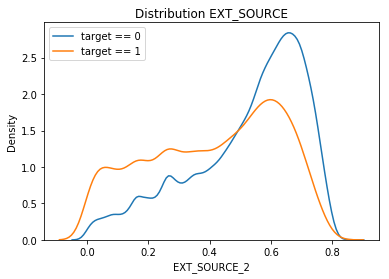

In [23]:
plt.figure(figsize = (6, 4))

# KDE plot of loans that were repaid on time
sns.kdeplot(application_train.loc[application_train['TARGET'] == 0, 'EXT_SOURCE_2'], label = 'target == 0')

# KDE plot of loans which were not repaid on time
sns.kdeplot(application_train.loc[application_train['TARGET'] == 1, 'EXT_SOURCE_2'], label = 'target == 1')

# Labeling of plot
plt.xlabel('EXT_SOURCE_2'); plt.ylabel('Density'); plt.title('Distribution EXT_SOURCE');

We can easily say that between 0.6 and 0.8 values of EXT_SOURCE_2, client pay their repayment.

### 2.3.2) DAYS_EMPLOYED

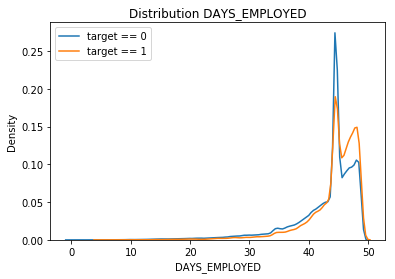

In [24]:
plt.figure(figsize = (6, 4))

# KDE plot of loans that were repaid on time
sns.kdeplot(application_train.loc[application_train['TARGET'] == 0, 'DAYS_EMPLOYED'] / 365, label = 'target == 0')

# KDE plot of loans which were not repaid on time
sns.kdeplot(application_train.loc[application_train['TARGET'] == 1, 'DAYS_EMPLOYED'] / 365, label = 'target == 1')

# Labeling of plot
plt.xlabel('DAYS_EMPLOYED'); plt.ylabel('Density'); plt.title('Distribution DAYS_EMPLOYED');

We can easily say that if client is employed more than 40 years, client paid their repayment.

# 3) Feature Engineering

To get better model to predict client is either pay his/her repayment or do not pay repayment, we need to create better features. Every possible new feature can be lead our model to success. New features and their formulas are following(Some of features taken from Koehrsen notebook);

    -INCOME_PER_PERSON: Total income divided by family members count.
    -CREDIT_INCOME_PERCENT: The percentage of the credit amount relative to a client's income.
    -ANNUITY_INCOME_PERCENT: The percentage of the loan annuity relative to a client's income.
    -CREDIT_TERM: The length of the payment in months (since the annuity is the monthly amount due.
    -DAYS_EMPLOYED_PERCENT: The percentage of the days employed relative to the client's age.
    -GOOD_PRICE_PERCENT: The percentage of the good price relative to client total income.
    -CHILDREN_PERCENT: The percentage of children count relative to client family members count.
    -OBS_30_CNT_SOCIAL_CIRCLE_REGION: Regional ratio of observable 30 day past due
    -DEF_30_CNT_SOCIAL_CIRCLE_REGION: Regional ratio of default 30 day past due
    -OBS_60_CNT_SOCIAL_CIRCLE_REGION: Regional ratio of observable 60 day past due
    -DEF_60_CNT_SOCIAL_CIRCLE_REGION: Regional ratio of observable 60 day past due


In [25]:
application_train_new = application_train.copy()
application_test_new = application_test.copy()

application_train_new['INCOME_PER_PERSON'] = application_train['AMT_INCOME_TOTAL'] / application_train['CNT_FAM_MEMBERS']
application_train_new['CREDIT_INCOME_PERCENT'] = application_train_new['AMT_CREDIT'] / application_train_new['AMT_INCOME_TOTAL']
application_train_new['ANNUITY_INCOME_PERCENT'] = application_train_new['AMT_ANNUITY'] / application_train_new['AMT_INCOME_TOTAL']
application_train_new['CREDIT_TERM'] = application_train_new['AMT_ANNUITY'] / application_train_new['AMT_CREDIT']
application_train_new['DAYS_EMPLOYED_PERCENT'] = application_train_new['DAYS_EMPLOYED'] / application_train_new['DAYS_BIRTH']
application_train_new['GOOD_PRICE_PERCENT'] = application_train_new['AMT_GOODS_PRICE'] / application_train_new['AMT_INCOME_TOTAL']
application_train_new['CHILDREN_PERCENT'] = application_train_new['CNT_CHILDREN'] / application_train_new['CNT_FAM_MEMBERS']
application_train_new['OBS_30_CNT_SOCIAL_CIRCLE_REGION'] = application_train_new.OBS_30_CNT_SOCIAL_CIRCLE * application_train_new.REGION_POPULATION_RELATIVE
application_train_new['DEF_30_CNT_SOCIAL_CIRCLE_REGION'] = application_train_new.DEF_30_CNT_SOCIAL_CIRCLE * application_train_new.REGION_POPULATION_RELATIVE
application_train_new['OBS_60_CNT_SOCIAL_CIRCLE_REGION'] = application_train_new.OBS_60_CNT_SOCIAL_CIRCLE * application_train_new.REGION_POPULATION_RELATIVE
application_train_new['DEF_60_CNT_SOCIAL_CIRCLE_REGION'] = application_train_new.DEF_60_CNT_SOCIAL_CIRCLE * application_train_new.REGION_POPULATION_RELATIVE

application_test_new['INCOME_PER_PERSON'] = application_train['AMT_INCOME_TOTAL'] / application_train['CNT_FAM_MEMBERS']
application_test_new['CREDIT_INCOME_PERCENT'] = application_test_new['AMT_CREDIT'] / application_test_new['AMT_INCOME_TOTAL']
application_test_new['ANNUITY_INCOME_PERCENT'] = application_test_new['AMT_ANNUITY'] / application_test_new['AMT_INCOME_TOTAL']
application_test_new['CREDIT_TERM'] = application_test_new['AMT_ANNUITY'] / application_test_new['AMT_CREDIT']
application_test_new['DAYS_EMPLOYED_PERCENT'] = application_test_new['DAYS_EMPLOYED'] / application_test_new['DAYS_BIRTH']
application_test_new['GOOD_PRICE_PERCENT'] = application_test_new['AMT_GOODS_PRICE'] / application_test_new['AMT_INCOME_TOTAL']
application_test_new['CHILDREN_PERCENT'] = application_test_new['CNT_CHILDREN'] / application_test_new['CNT_FAM_MEMBERS']
application_test_new['OBS_30_CNT_SOCIAL_CIRCLE_REGION'] = application_test_new.OBS_30_CNT_SOCIAL_CIRCLE * application_test_new.REGION_POPULATION_RELATIVE
application_test_new['DEF_30_CNT_SOCIAL_CIRCLE_REGION'] = application_test_new.DEF_30_CNT_SOCIAL_CIRCLE * application_test_new.REGION_POPULATION_RELATIVE
application_test_new['OBS_60_CNT_SOCIAL_CIRCLE_REGION'] = application_test_new.OBS_60_CNT_SOCIAL_CIRCLE * application_test_new.REGION_POPULATION_RELATIVE
application_test_new['DEF_60_CNT_SOCIAL_CIRCLE_REGION'] = application_test_new.DEF_60_CNT_SOCIAL_CIRCLE * application_test_new.REGION_POPULATION_RELATIVE

After creating these features, we need to check missing and infinite values for them again.

In [26]:
application_train_new.replace([np.inf,-np.inf],np.nan,inplace=True)
application_train_new.isnull().sum().tail(11)

INCOME_PER_PERSON                  0
CREDIT_INCOME_PERCENT              0
ANNUITY_INCOME_PERCENT             0
CREDIT_TERM                        0
DAYS_EMPLOYED_PERCENT              0
GOOD_PRICE_PERCENT                 0
CHILDREN_PERCENT                   0
OBS_30_CNT_SOCIAL_CIRCLE_REGION    0
DEF_30_CNT_SOCIAL_CIRCLE_REGION    0
OBS_60_CNT_SOCIAL_CIRCLE_REGION    0
DEF_60_CNT_SOCIAL_CIRCLE_REGION    0
dtype: int64

In [27]:
application_test_new.replace([np.inf,-np.inf],np.nan,inplace=True)
application_test_new.isnull().sum().tail(11)

INCOME_PER_PERSON                  0
CREDIT_INCOME_PERCENT              0
ANNUITY_INCOME_PERCENT             0
CREDIT_TERM                        0
DAYS_EMPLOYED_PERCENT              0
GOOD_PRICE_PERCENT                 0
CHILDREN_PERCENT                   0
OBS_30_CNT_SOCIAL_CIRCLE_REGION    0
DEF_30_CNT_SOCIAL_CIRCLE_REGION    0
OBS_60_CNT_SOCIAL_CIRCLE_REGION    0
DEF_60_CNT_SOCIAL_CIRCLE_REGION    0
dtype: int64

# 4) Feature Importance and Target Variable Analysis

After gather and clean all features, now we can start to determine best features that explain target variable. We are going to use RandomForest and Logistic Regression to determine these features. After implementation these alghoritms, we select for these alghoritms best to features and look distribution of target variable.

## 4.1) RandomForestClassifier for Feature Importance

In [28]:
a = application_train_new.columns.difference(application_test_new.columns)
a= a.drop('TARGET')

application_train_new.drop(a,inplace=True,axis=1)

In [29]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler

scalar = StandardScaler()
X = application_train_new.drop('TARGET',axis=1)
y = application_train_new.TARGET
X_scaled = scalar.fit_transform(X)

rf = RandomForestClassifier(n_jobs=-1,n_estimators=30)
rf.fit(X_scaled,y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=30, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [30]:
result_rf = pd.DataFrame()
result_rf['Features'] = X.columns
result_rf ['Values'] = rf.feature_importances_
result_rf.sort_values('Values',inplace=True, ascending = False)
result_rf.head(2)

,Features,Values
30,EXT_SOURCE_2,0.052287
31,EXT_SOURCE_3,0.048684


We already look realation between EXTRA_SOURCE and Target variable.

## 4.2) Logistic Regression

In [31]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression()
lr.fit(X_scaled,y)
a = lr.coef_[0]
coef = pd.Series(a, index=X.columns)
coef.sort_values(inplace=True)

coef.tail(2)

DAYS_BIRTH    0.357050
AMT_CREDIT    0.975591
dtype: float64

### 4.2.1) DAYS_ID_PUBLISH

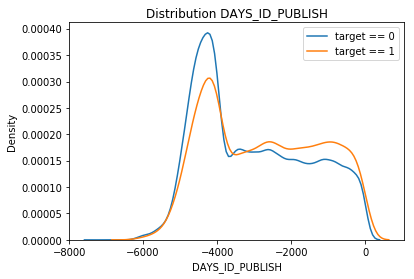

In [32]:
plt.figure(figsize = (6, 4))

# KDE plot of loans that were repaid on time
sns.kdeplot(application_train.loc[application_train['TARGET'] == 0, 'DAYS_ID_PUBLISH'], label = 'target == 0')

# KDE plot of loans which were not repaid on time
sns.kdeplot(application_train.loc[application_train['TARGET'] == 1, 'DAYS_ID_PUBLISH'], label = 'target == 1')

# Labeling of plot
plt.xlabel('DAYS_ID_PUBLISH'); plt.ylabel('Density'); plt.title('Distribution DAYS_ID_PUBLISH');

### 4.2.2) DAYS_LAST_PHONE_CHANGE

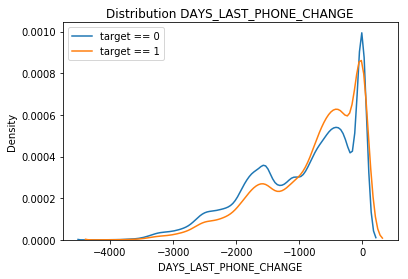

In [33]:
plt.figure(figsize = (6, 4))

# KDE plot of loans that were repaid on time
sns.kdeplot(application_train.loc[application_train['TARGET'] == 0, 'DAYS_LAST_PHONE_CHANGE'], label = 'target == 0')

# KDE plot of loans which were not repaid on time
sns.kdeplot(application_train.loc[application_train['TARGET'] == 1, 'DAYS_LAST_PHONE_CHANGE'], label = 'target == 1')

# Labeling of plot
plt.xlabel('DAYS_LAST_PHONE_CHANGE'); plt.ylabel('Density'); plt.title('Distribution DAYS_LAST_PHONE_CHANGE');

# 5) Models Implementation and Feature Elimination

Now our dataset is ready for build machine learning models. We use Principal Component Analysis and Recursive Feature Elimination techniques for feature elimination. PCA take best features and combine them to gather best explained features. Also we implement boostrap sampling because our dataset is rare event. There is few ones in dataset. We try to increase number of the ones by using boostrap sampling. We are going to implement Ridge Classifier, Logistic Regression, Random Forest Classifier, Linear Discriminant Analysis and Quadratic Discriminant Analysis alghoritms. We select best alghoritm or combine them for better results.

## 5.1) Principal Component Analysis without Boostrap Sampling

In [37]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.linear_model import RidgeClassifier
from sklearn.svm import SVC
from sklearn.linear_model import ElasticNet, LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
import datetime

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)
result_df = pd.DataFrame(data=np.ones(shape=(5,9)),columns=['Model','TruePositive','FalsePositive','FalseNegative','TrueNegative','Accuracy'
                                                         ,'Precision','Recall','Specifity'])

pca = PCA(n_components = 100)
pca_X_train = pd.DataFrame(pca.fit_transform(X_train))
pca_X_train.index = X_train.index

pca_X_test = pd.DataFrame(pca.transform(X_test))
pca_X_test.index = X_test.index

clf_1 = RidgeClassifier()
clf_1.fit(pca_X_train, y_train)
tn, fn,fp, tp = confusion_matrix(y_test,clf_1.predict(pca_X_test)).ravel()
result_df.loc[0,'Model'] = str(clf_1).split('(')[0]
result_df.loc[0,'TruePositive'] = tp
result_df.loc[0,'FalsePositive'] = fp
result_df.loc[0,'FalseNegative'] = fn
result_df.loc[0,'TrueNegative'] = tn
result_df.loc[0,'Accuracy'] = (tp+tn)/(tp+tn+fp+fn)
result_df.loc[0,'Precision'] = tp/(tp+fp)
result_df.loc[0,'Recall'] = tp / (tp+fn)
result_df.loc[0,'Specifity'] = tn / (tn+fp)
print(datetime.datetime.now())

clf_4 = LogisticRegression(C=0.05)
clf_4.fit(pca_X_train, y_train)
tn, fn,fp, tp = confusion_matrix(y_test,clf_4.predict(pca_X_test)).ravel()
result_df.loc[1,'Model'] = str(clf_4).split('(')[0]
result_df.loc[1,'TruePositive'] = tp
result_df.loc[1,'FalsePositive'] = fp
result_df.loc[1,'FalseNegative'] = fn
result_df.loc[1,'TrueNegative'] = tn
result_df.loc[1,'Accuracy'] = (tp+tn)/(tp+tn+fp+fn)
result_df.loc[1,'Precision'] = tp/(tp+fp)
result_df.loc[1,'Recall'] = tp / (tp+fn)
result_df.loc[1,'Specifity'] = tn / (tn+fp)
print(datetime.datetime.now())

clf_5 = RandomForestClassifier(n_jobs=-1)
clf_5.fit(pca_X_train,y_train)
tn, fn,fp, tp = confusion_matrix(y_test,clf_5.predict(pca_X_test)).ravel()
result_df.loc[2,'Model'] = str(clf_5).split('(')[0]
result_df.loc[2,'TruePositive'] = tp
result_df.loc[2,'FalsePositive'] = fp
result_df.loc[2,'FalseNegative'] = fn
result_df.loc[2,'TrueNegative'] = tn
result_df.loc[2,'Accuracy'] = (tp+tn)/(tp+tn+fp+fn)
result_df.loc[2,'Precision'] = tp/(tp+fp)
result_df.loc[2,'Recall'] = tp / (tp+fn)
result_df.loc[2,'Specifity'] = tn / (tn+fp)
print(datetime.datetime.now())

clf_6 = LinearDiscriminantAnalysis()
clf_6.fit(pca_X_train, y_train)
tn, fn,fp, tp= confusion_matrix(y_test,clf_6.predict(pca_X_test)).ravel()
result_df.loc[3,'Model'] = str(clf_6).split('(')[0]
result_df.loc[3,'TruePositive'] = tp
result_df.loc[3,'FalsePositive'] = fp
result_df.loc[3,'FalseNegative'] = fn
result_df.loc[3,'TrueNegative'] = tn
result_df.loc[3,'Accuracy'] = (tp+tn)/(tp+tn+fp+fn)
result_df.loc[3,'Precision'] = tp/(tp+fp)
result_df.loc[3,'Recall'] = tp / (tp+fn)
result_df.loc[3,'Specifity'] = tn / (tn+fp)
print(datetime.datetime.now())

clf_7 = QuadraticDiscriminantAnalysis()
clf_7.fit(pca_X_train,y_train)
tn, fn,fp, tp = confusion_matrix(y_test,clf_7.predict(pca_X_test)).ravel()
result_df.loc[4,'Model'] = str(clf_7).split('(')[0]
result_df.loc[4,'TruePositive'] = tp
result_df.loc[4,'FalsePositive'] = fp
result_df.loc[4,'FalseNegative'] = fn
result_df.loc[4,'TrueNegative'] = tn
result_df.loc[4,'Accuracy'] = (tp+tn)/(tp+tn+fp+fn)
result_df.loc[4,'Precision'] = tp/(tp+fp)
result_df.loc[4,'Recall'] = tp / (tp+fn)
result_df.loc[4,'Specifity'] = tn / (tn+fp)
print(datetime.datetime.now())

2018-08-14 23:30:15.450992
2018-08-14 23:30:52.460391
2018-08-14 23:31:11.811930
2018-08-14 23:31:14.256898
2018-08-14 23:31:20.225343


In [38]:
result_df

,Model,TruePositive,FalsePositive,FalseNegative,TrueNegative,Accuracy,Precision,Recall,Specifity
0,RidgeClassifier,1.0,4948.0,0.0,56554.0,0.919549,0.000202,1.000000,0.919547
1,LogisticRegression,1.0,4948.0,2.0,56552.0,0.919516,0.000202,0.333333,0.919545
2,RandomForestClassifier,50.0,4899.0,103.0,56451.0,0.918671,0.010103,0.326797,0.920147
3,LinearDiscriminantAnalysis,118.0,4831.0,137.0,56417.0,0.919223,0.023843,0.462745,0.921124
4,QuadraticDiscriminantAnalysis,2278.0,2671.0,14573.0,41981.0,0.719623,0.460295,0.135185,0.940182


## 5.2) Principal Component Analysis with Boostrap Resampling

In [34]:
from sklearn.utils import resample
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
df7 = application_train_new.copy()
df7.drop('TARGET',inplace=True,axis=1)
df7['TARGET'] = application_train_new['TARGET']

values = df7[df7.TARGET==1].values
df8 = df7.copy()
# configure bootstrap
n_iterations = 10
n_size = int(len(df7[df7.TARGET==1]) * 0.001)
# run bootstrap
for i in range(n_iterations):
    # prepare train and test sets
    train = resample(values, n_samples=n_size)
    test = np.array([a for a in values if a.tolist() not in train.tolist()])
    test_df = pd.DataFrame(test, columns = df7.columns)
    # fit model
    model = DecisionTreeClassifier()
    model.fit(train[:,:-1], train[:,-1])
    # evaluate model
    predictions = model.predict(test[:,:-1])
    score = accuracy_score(test[:,-1], predictions)
    if(score >0.9):
        df8 = pd.concat([df8,test_df])
        df8.reset_index(drop=True, inplace = True)

In [41]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.linear_model import RidgeClassifier
from sklearn.svm import SVC
from sklearn.linear_model import ElasticNet, LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
import datetime

X_train, X_test, y_train, y_test = train_test_split(df8.iloc[:,:-1],df8.iloc[:,-1],test_size=0.2,random_state=42)
result_df_boostrap = pd.DataFrame(data=np.ones(shape=(5,9)),columns=['Model','TruePositive','FalsePositive','FalseNegative','TrueNegative','Accuracy'
                                                         ,'Precision','Recall','Specifity'])

scalar = StandardScaler()
X_train_scaled = scalar.fit_transform(X_train)
X_test_scaled = scalar.transform(X_test)

pca = PCA(n_components = 100)
pca_X_train = pd.DataFrame(pca.fit_transform(X_train_scaled))
pca_X_train.index = X_train.index

pca_X_test = pd.DataFrame(pca.transform(X_test_scaled))
pca_X_test.index = X_test.index

clf_1 = RidgeClassifier()
clf_1.fit(pca_X_train, y_train)
tn, fn,fp, tp = confusion_matrix(y_test,clf_1.predict(pca_X_test)).ravel()
result_df_boostrap.loc[0,'Model'] = str(clf_1).split('(')[0]
result_df_boostrap.loc[0,'TruePositive'] = tp
result_df_boostrap.loc[0,'FalsePositive'] = fp
result_df_boostrap.loc[0,'FalseNegative'] = fn
result_df_boostrap.loc[0,'TrueNegative'] = tn
result_df_boostrap.loc[0,'Accuracy'] = (tp+tn)/(tp+tn+fp+fn)
result_df_boostrap.loc[0,'Precision'] = tp/(tp+fp)
result_df_boostrap.loc[0,'Recall'] = tp / (tp+fn)
result_df_boostrap.loc[0,'Specifity'] = tn / (tn+fp)
print(datetime.datetime.now())


clf_4 = LogisticRegression(C=0.05)
clf_4.fit(pca_X_train, y_train)
tn, fn,fp, tp = confusion_matrix(y_test,clf_4.predict(pca_X_test)).ravel()
result_df_boostrap.loc[1,'Model'] = str(clf_4).split('(')[0]
result_df_boostrap.loc[1,'TruePositive'] = tp
result_df_boostrap.loc[1,'FalsePositive'] = fp
result_df_boostrap.loc[1,'FalseNegative'] = fn
result_df_boostrap.loc[1,'TrueNegative'] = tn
result_df_boostrap.loc[1,'Accuracy'] = (tp+tn)/(tp+tn+fp+fn)
result_df_boostrap.loc[1,'Precision'] = tp/(tp+fp)
result_df_boostrap.loc[1,'Recall'] = tp / (tp+fn)
result_df_boostrap.loc[1,'Specifity'] = tn / (tn+fp)
print(datetime.datetime.now())

clf_5 = RandomForestClassifier(n_jobs=-1)
clf_5.fit(pca_X_train,y_train)
tn, fn,fp, tp = confusion_matrix(y_test,clf_5.predict(pca_X_test)).ravel()
result_df_boostrap.loc[2,'Model'] = str(clf_5).split('(')[0]
result_df_boostrap.loc[2,'TruePositive'] = tp
result_df_boostrap.loc[2,'FalsePositive'] = fp
result_df_boostrap.loc[2,'FalseNegative'] = fn
result_df_boostrap.loc[2,'TrueNegative'] = tn
result_df_boostrap.loc[2,'Accuracy'] = (tp+tn)/(tp+tn+fp+fn)
result_df_boostrap.loc[2,'Precision'] = tp/(tp+fp)
result_df_boostrap.loc[2,'Recall'] = tp / (tp+fn)
result_df_boostrap.loc[2,'Specifity'] = tn / (tn+fp)
print(datetime.datetime.now())

clf_6 = LinearDiscriminantAnalysis()
clf_6.fit(pca_X_train, y_train)
tn, fn,fp, tp= confusion_matrix(y_test,clf_6.predict(pca_X_test)).ravel()
result_df_boostrap.loc[3,'Model'] = str(clf_6).split('(')[0]
result_df_boostrap.loc[3,'TruePositive'] = tp
result_df_boostrap.loc[3,'FalsePositive'] = fp
result_df_boostrap.loc[3,'FalseNegative'] = fn
result_df_boostrap.loc[3,'TrueNegative'] = tn
result_df_boostrap.loc[3,'Accuracy'] = (tp+tn)/(tp+tn+fp+fn)
result_df_boostrap.loc[3,'Precision'] = tp/(tp+fp)
result_df_boostrap.loc[3,'Recall'] = tp / (tp+fn)
result_df_boostrap.loc[3,'Specifity'] = tn / (tn+fp)
print(datetime.datetime.now())

clf_7 = QuadraticDiscriminantAnalysis()
clf_7.fit(pca_X_train,y_train)
tn, fn,fp, tp = confusion_matrix(y_test,clf_7.predict(pca_X_test)).ravel()
result_df_boostrap.loc[4,'Model'] = str(clf_7).split('(')[0]
result_df_boostrap.loc[4,'TruePositive'] = tp
result_df_boostrap.loc[4,'FalsePositive'] = fp
result_df_boostrap.loc[4,'FalseNegative'] = fn
result_df_boostrap.loc[4,'TrueNegative'] = tn
result_df_boostrap.loc[4,'Accuracy'] = (tp+tn)/(tp+tn+fp+fn)
result_df_boostrap.loc[4,'Precision'] = tp/(tp+fp)
result_df_boostrap.loc[4,'Recall'] = tp / (tp+fn)
result_df_boostrap.loc[4,'Specifity'] = tn / (tn+fp)
print(datetime.datetime.now())

2018-08-14 23:42:49.395226
2018-08-14 23:42:57.844451
2018-08-14 23:43:22.598609
2018-08-14 23:43:27.484209
2018-08-14 23:43:39.271199


In [42]:
result_df_boostrap

,Model,TruePositive,FalsePositive,FalseNegative,TrueNegative,Accuracy,Precision,Recall,Specifity
0,RidgeClassifier,35010.0,19323.0,18048.0,38724.0,0.663643,0.644360,0.659844,0.667115
1,LogisticRegression,35280.0,19053.0,17947.0,38825.0,0.666982,0.649329,0.662822,0.670808
2,RandomForestClassifier,50042.0,4291.0,386.0,56386.0,0.957905,0.921024,0.992346,0.929281
3,LinearDiscriminantAnalysis,35011.0,19322.0,18048.0,38724.0,0.663652,0.644378,0.659850,0.667126
4,QuadraticDiscriminantAnalysis,48819.0,5514.0,47743.0,9029.0,0.520661,0.898515,0.505572,0.620849


# 6) Conclusion

According to these result our best model is Random Forest Classifier by using boostrap resampling and PCA for dimesonality reduction.